In [1]:
from shapely.geometry import Point
import pointpats
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.strtree import STRtree
import numpy as np
from SimuSamp.functions.load.SpatDat import SpatDat
from SimuSamp.functions.compute.n_core_sampler import sample_n_cores

# Exploration of Specimen 03_B Using SpatDat

In [2]:
parent_filepath = "../../../../Simulated WS Sampling/block_data"

sampleids = ["03_B"]

microns_per_pixel=0.22715
mm2_per_pixels2 = (microns_per_pixel / 1000) ** 2

r = 0.5 * 1000 / microns_per_pixel
n = 10

In [3]:
spatdat = SpatDat(sampleid="03_B", parent_filepath=parent_filepath)

In [4]:
cells = spatdat.subset_cells("extended_partition")
tum_cells = spatdat.subset_cells("tumour")
im_cells = spatdat.subset_cells("IM")
tum = spatdat.subset_annotation("tumour")
ext_partition = spatdat.subset_annotation("extended_partition")
im = spatdat.subset_annotation("IM")
outer_im = spatdat.subset_annotation("outer_IM")

In [5]:
im_polygon = gpd.GeoDataFrame(geometry=[im])

In [6]:
tum_polygon = gpd.GeoDataFrame(geometry=[tum])

In [7]:
def int_area(point, poly, r=0.2):

    intersection_area = point.buffer(r).intersection(poly).area
    core_area = np.pi * r**2

    fraction = intersection_area / core_area

    return fraction

In [8]:
# Generates random points inside polygon
random_points = spatdat.poisson_distribution("tumour")

print(f"{len(random_points)} points calculated.")

1592 points calculated.


In [9]:
# Shuffle gdf for randomization
random_points = random_points.sample(frac=1).reset_index(drop=True)

point_list = []
tree = STRtree(point_list)
for idx, point in random_points.iterrows():
    if not any(tree.query(point.geometry, predicate="dwithin", distance=2*r)):
        
        # Evaluate core eligibility
        fraction = int_area(point.geometry, tum, r)
        
        if fraction >= 0.5:
            point_list.append(point.geometry)
            tree = STRtree(point_list)

In [10]:
filtered_gdf = gpd.GeoDataFrame(geometry=point_list)
filtered_gdf = filtered_gdf.drop(0, axis=0) # Drop initial point
filtered_gdf_buffer = filtered_gdf.buffer(r)

n_samples = min([n, int(len(filtered_gdf_buffer))])

sampled_gdf = filtered_gdf_buffer.sample(n_samples)

n_sampled = len(sampled_gdf)

n_cores_sampled:  10


<Axes: >

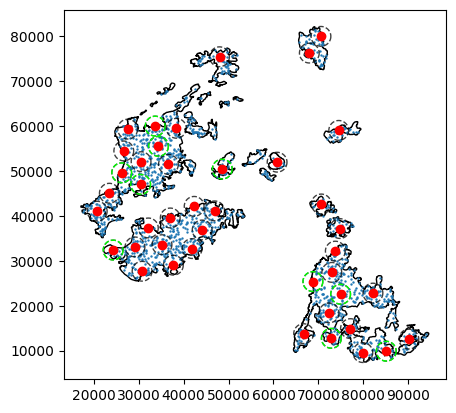

In [11]:
print("n_cores_sampled: ", n_sampled)
tum_polygon.plot(color="None")
random_points.plot(ax=plt.gca(), markersize=0.5)
filtered_gdf.plot(ax=plt.gca(), color="red")
filtered_gdf_buffer.plot(ax=plt.gca(), color="None", edgecolor="black", alpha=0.75, linestyle="--")
sampled_gdf.plot(ax=plt.gca(), color="None", edgecolor="lime", linestyle="--")

In [12]:
cores = sampled_gdf.reset_index(drop=True)

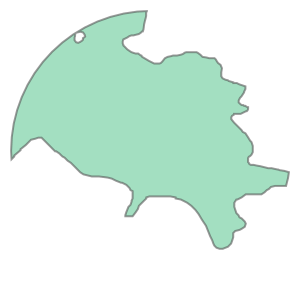

In [13]:
core = cores.geometry[8].intersection(ext_partition)
core

In [14]:
core_gdf = gpd.GeoDataFrame(geometry=[core])
core_cells = gpd.sjoin(cells, core_gdf, predicate="within")

In [15]:
cores = gpd.GeoDataFrame(geometry=cores)

In [16]:
core_rand_points = gpd.sjoin(random_points, cores, predicate="within")

<Axes: >

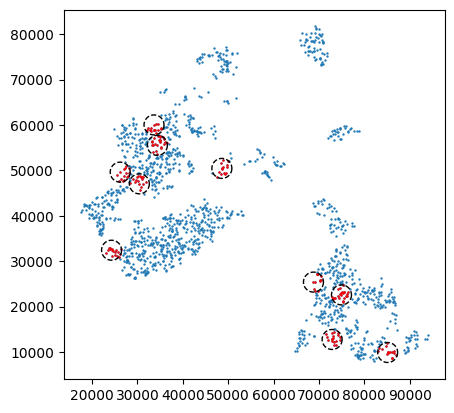

In [17]:
random_points.plot(markersize=0.5)
core_rand_points.plot(color="red", ax=plt.gca(), markersize=0.5)
cores.plot(ax=plt.gca(), color="None", edgecolor="black", linestyle="--")

In [18]:
random_points = pointpats.random.poisson(core, size=len(core_cells))
random_points = [Point(p) for p in random_points]
random_gdf = gpd.GeoDataFrame(geometry=random_points)

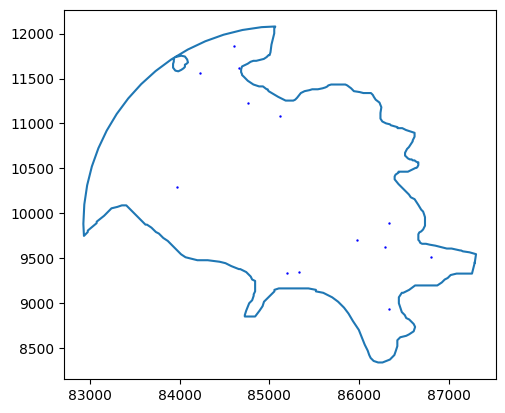

In [19]:
random_gdf.plot(color="blue", markersize=0.5)
plt.plot(*core.exterior.xy)

In [20]:
res = sample_n_cores(spatdat, region="tumour")

In [21]:
eligible_points = gpd.GeoDataFrame(res, geometry="eligible_points")
sampled_cores = gpd.GeoDataFrame(res, geometry="cores")

<Axes: >

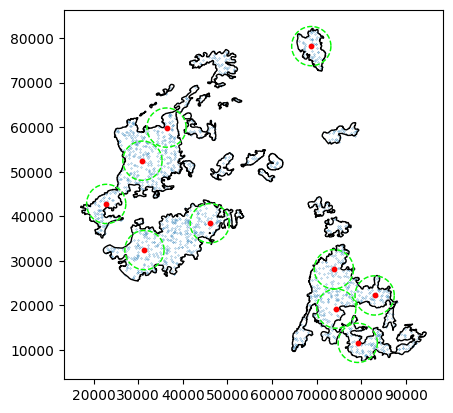

In [27]:
idx = 2999
radius = eligible_points.iloc[[idx]]["core_radius"][idx]
region = eligible_points.iloc[[idx]]["region"][idx]
spatdat.poisson_cells[region].plot(markersize=0.05)
tum_polygon.plot(ax=plt.gca(), color="None")
if region == "IM":
    im_polygon.plot(ax=plt.gca(), color="None", edgecolor="black", linestyle="--")
eligible_points.iloc[[idx]].plot(ax=plt.gca(), color="red", markersize=10)
eligible_points.iloc[[idx]].buffer(radius * 1000 / microns_per_pixel).plot(ax=plt.gca(), color="None", edgecolor="gainsboro", linestyle="--")
sampled_cores.iloc[[idx]].plot(ax=plt.gca(), color="None", edgecolor="lime", linestyle="--")

## Exploring SpatDat for TMA cores

In [3]:
spatdat = SpatDat(sampleid="03_B", parent_filepath=parent_filepath, tma=True)

In [16]:
spatdat.core_map

,TMAx,TMAy,Coords,PatientID,BlockDesignation,SampleID,Region,QC1_Included,QC2_Included,Annotation_File
0,12,16,12_16,3,B,03_B,T,1,1,_119682_4209+10940+7999+7999
1,13,1,13_1,3,B,03_B,IM,1,1,_119682_107701+3389+7999+7999
2,13,2,13_2,3,B,03_B,IM,1,1,_119682_100435+3242+7999+7999


In [22]:
cells, annos = spatdat.subset_cores(core_id="13_1")

pos = annos[annos["layer"] == "positive_regions"]

neg = annos[annos["layer"] == "negative_regions"]

analysis_area = annos[annos["layer"] == "analysis_area"]

C:\Users\Michael\AppData\Roaming\Python\Python311\site-packages\geopandas\plotting.py:968: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  return plot_dataframe(data, *args, **kwargs)


<Axes: >

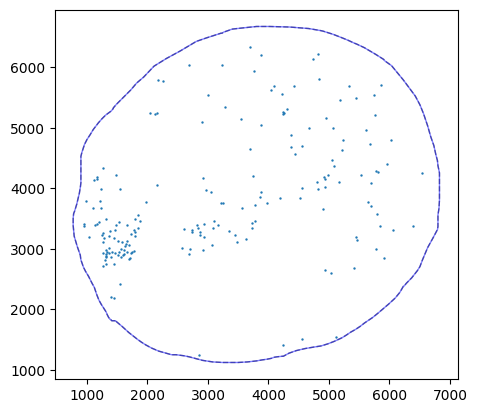

In [23]:
analysis_area.plot(color="None", edgecolor="black", linestyle="--", alpha=0.5)

pos.plot(ax=plt.gca(), color="None", edgecolor="blue", linestyle="-", alpha=0.5)

neg.plot(ax=plt.gca(), color="None", edgecolor="red", linestyle="--", alpha=0.5)

cells.plot(ax=plt.gca(), markersize=0.5)